In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
from scipy.spatial.transform import Rotation
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [3]:
img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()
dm[dm == 0] = np.nan

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)

FileNotFoundError: No such file: '/home/julian/code/uni/dmcp/notebooks/c:/data/middlebury/all/data/ladder1/disp0.pfm'

In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)
pts_orig = pts
mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

In [5]:
#mesh = pv.PolyData(pts)
#mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
#mesh.plot(scalars='colors',rgb=True,notebook=False, render_points_as_spheres=True)

In [6]:
#from src.dmcpworkflow.h_backproject_mesh import capture_depth
#from scipy.spatial.transform import Rotation
#ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
#P = cam @ ext
#R  = Rotation.from_euler("xyz",[0,0,0],degrees=True).as_matrix()
#T = np.array([[0,0,0]]).T
#trans = np.hstack((R,T))
#trans = np.vstack((trans,[0,0,0,1]))
#
#P_captured = P @ la.inv(trans)
#dm_captured = capture_depth(mesh, P_captured, cam, dm.shape[0], dm.shape[1])

In [7]:

#plt.figure()
#plt.imshow(dm)
#
#plt.figure()
#plt.imshow(dm_captured)
#
#plt.show()

In [8]:
#diffim = np.abs(dm - dm_captured)

#plt.figure()
#plt.imshow(diffim)
#plt.show()

In [9]:
#pts_captured = []
#invK = la.inv(cam)
#for y in range(dm_captured.shape[0]):
#    for x in range(dm_captured.shape[1]):
#        dist = dm_captured[y,x]
#        pt = dist * (invK @ [x,y,1])
#        pts_captured.append(pt)
#
#pts_captured = np.array(pts_captured)

points align very closely only on identiy matrix!

In [10]:
#mesh_captured = pv.PolyData(pts_captured)
#
#pl = pv.Plotter(off_screen=False,notebook=False)
#pl.add_mesh(mesh, scalars="colors",rgb=True)
#pl.add_mesh(mesh_captured, color="orange")
##pl.show()

# open3d depth map

In [11]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pts_orig_cleaned = np.nan_to_num(pts_orig, 0)
pcd.points = o3d.utility.Vector3dVector(pts_orig_cleaned)
pcd.colors =  o3d.utility.Vector3dVector(np.reshape(im,(-1,3)) / 255.0)
print(pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PointCloud with 2073600 points.


1733.68
[[   1733.68       0.00     819.72]
 [      0.00    1733.68     957.55]
 [      0.00       0.00       1.00]]
True
1080 1920
(1733.68, 1733.68) (819.72, 957.55)
1080 1920
[[   1733.68       0.00     539.50]
 [      0.00    1733.68     530.00]
 [      0.00       0.00       1.00]]
True
1080 1061
(1733.68, 1733.68) (539.5, 530.0)


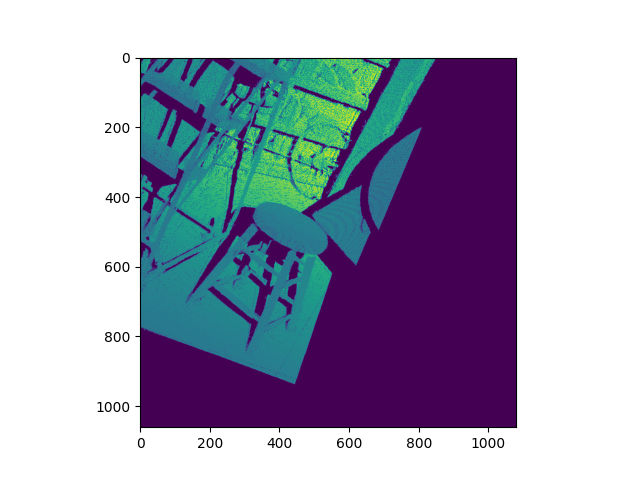

In [12]:


height, width = dm.shape
intrinsics = cam
R  = Rotation.from_euler("xyz",[10,-10,25],degrees=True).as_matrix()
T = np.array([[750,-200,530]]).T
extrinsics = np.vstack((np.hstack((R,T)),[0,0,0,1])) # needs to be 4x4

# extract intrinsics
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]

print(fx)


def custom_draw_geometry(pcd, width, height):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    vis :o3d.visualization.Visualizer = o3d.visualization.Visualizer()
    
    camera_parameters : o3d.camera.PinholeCameraParameters = o3d.camera.PinholeCameraParameters()
    camera_parameters.extrinsic = extrinsics
    #camera_parameters.intrinsic.set_intrinsics(width=width, height=height, fx=fx, fy=fy, cx=width/2.0-0.5, cy=height/2.0-0.5)
    camera_parameters.intrinsic.set_intrinsics(width=width,height=height,fx=fx, fy=fy, cx=cx, cy=cy)

    print(camera_parameters.intrinsic.intrinsic_matrix)
    print(camera_parameters.intrinsic.is_valid())
    print(camera_parameters.intrinsic.width,camera_parameters.intrinsic.height )
    print(camera_parameters.intrinsic.get_focal_length(),camera_parameters.intrinsic.get_principal_point() )

    vis.create_window(width=width,height=height,visible=True)
    ro :o3d.visualization.RenderOptions = vis.get_render_option()
    ro.background_color = (0.85,0.85,0.85)
    ro.point_size = 1
    vis.add_geometry(pcd)
    
    print(width, height)
    control: o3d.visualization.ViewControl = vis.get_view_control()
    control.convert_from_pinhole_camera_parameters(camera_parameters,allow_arbitrary=True)
    param = control.convert_to_pinhole_camera_parameters()
    print(param.intrinsic.intrinsic_matrix)
    print(param.intrinsic.is_valid())
    print(param.intrinsic.width,param.intrinsic.height )
    print(param.intrinsic.get_focal_length(),param.intrinsic.get_principal_point() )

    vis.update_renderer()
    vis.poll_events()

    depth = vis.capture_depth_float_buffer(do_render=True)

    vis.close()

    return np.array(depth), param.intrinsic.intrinsic_matrix

depth, K_captured = custom_draw_geometry(pcd,width,height)

plt.figure()
plt.imshow(depth)

In [13]:
from src.pycv.dmcp import dm_to_world
P_captured = K_captured @ extrinsics[:3,:]
dmpts = [[x,y] for y in range(depth.shape[0]) for x in range(depth.shape[1])]
dmpts = np.array(dmpts)

world_pts = dm_to_world(depth, K_captured, P_captured, dmpts)
world_pts

array([[   -678.20,     417.97,    -498.75],
       [   -678.20,     417.97,    -498.75],
       [   -678.20,     417.97,    -498.75],
       ...,
       [   -678.20,     417.97,    -498.75],
       [   -678.20,     417.97,    -498.75],
       [   -678.20,     417.97,    -498.75]], dtype=float32)

In [14]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(cps_mesh, color="cyan", point_size=7)
pl.add_mesh(mesh, scalars="colors",rgb=True, point_size=5)
pl.show()

# Pyrender Depth Map

In [56]:
import trimesh
import pyrender
R  = Rotation.from_euler("xyz",[0,0,0],degrees=True).as_matrix()

R_opengl = Rotation.from_euler("xyz",[180,0,0],degrees=True).as_matrix()
R = R_opengl @ R

T = np.array([[0,0,0]]).T

mesh = pyrender.Mesh.from_points(pts_orig_cleaned, colors=np.reshape(im,(-1,3)))


In [16]:


camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.414)
camera_pose= la.inv(extrinsics)
print(camera_pose)
T = camera_pose[:3,-1]
camera_pose = np.eye(4)
#camera_pose[0,-1] = T[0] # x
#camera_pose[1,-1] = -T[2] # -z
#camera_pose[2,-1] = T[1] # y
print(camera_pose)
#scene = pyrender.Scene()
#scene.add(mesh)
#scene.add(camera,pose=camera_pose)
#scene.add(light,pose=camera_pose)
#r = pyrender.OffscreenRenderer(400, 400)

#pyrender.Viewer(scene, use_raymond_lighting=True)

#color, depth = r.render(scene)
#plt.figure()
#plt.subplot(1,2,1)
#plt.imshow(color)
#plt.subplot(1,2,2)
#plt.imshow(depth)
#plt.show()


[[      0.89       0.42       0.17    -678.20]
 [     -0.44       0.88       0.17     417.97]
 [     -0.08      -0.23       0.97    -498.75]
 [      0.00       0.00       0.00       1.00]]
[[      1.00       0.00       0.00       0.00]
 [      0.00       1.00       0.00       0.00]
 [      0.00       0.00       1.00       0.00]
 [      0.00       0.00       0.00       1.00]]


In [66]:
#mesh = trimesh.load("../demo/lidar_roi.ply")
#mesh = pyrender.Mesh.from_trimesh(mesh)
sphere = trimesh.creation.uv_sphere(radius=500)
sphere.visual.vertex_colors = [1.0,0,0]
rSphere =pyrender.Mesh.from_trimesh(sphere)
pose = np.eye(4)
pose[0,-1] = 0 # right direction "x"
pose[1,-1] = 0 # down direction
pose[2,-1] = 0 # forward direction

scene = pyrender.Scene()
scene.add(mesh)
scene.add(rSphere, pose=pose)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True)

None


[[      1.00       0.00       0.00       0.10]
 [      0.00       0.00      -1.00      -0.16]
 [      0.00       1.00       0.00       0.13]
 [      0.00       0.00       0.00       1.00]]


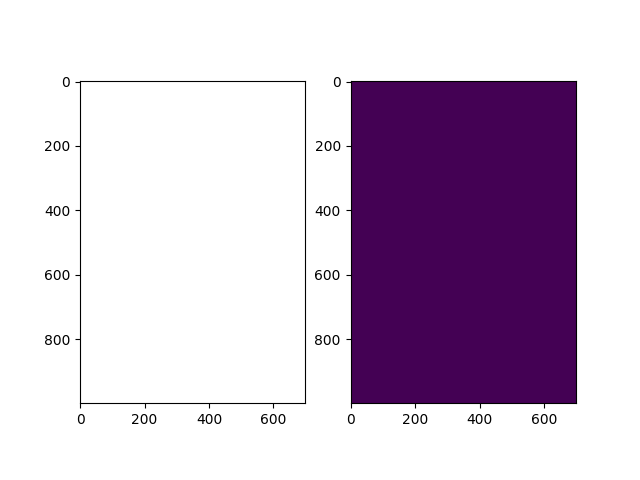

In [70]:
scene = pyrender.Scene()
scene.add(mesh)
scene.add(rSphere, pose=pose)

camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0, znear=0, zfar=None)
camera_pose = np.array([
    [1.0, 0.0,  0.0, 0.1],
    [0.0, 0.0, -1.0, -0.16],
    [0.0, 1.0,  0.0, 0.13],
    [0.0, 0.0,  0.0, 1.0],
])
print(camera_pose)
scene.add(camera, pose=camera_pose)


light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
innerConeAngle=np.pi/16.0,
outerConeAngle=np.pi/6.0)
scene.add(light, pose=camera_pose)

r = pyrender.OffscreenRenderer(viewport_width=700,viewport_height=1000, point_size=1)
color, depth = r.render(scene)

r.delete()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
plt.imshow(depth)
plt.show()

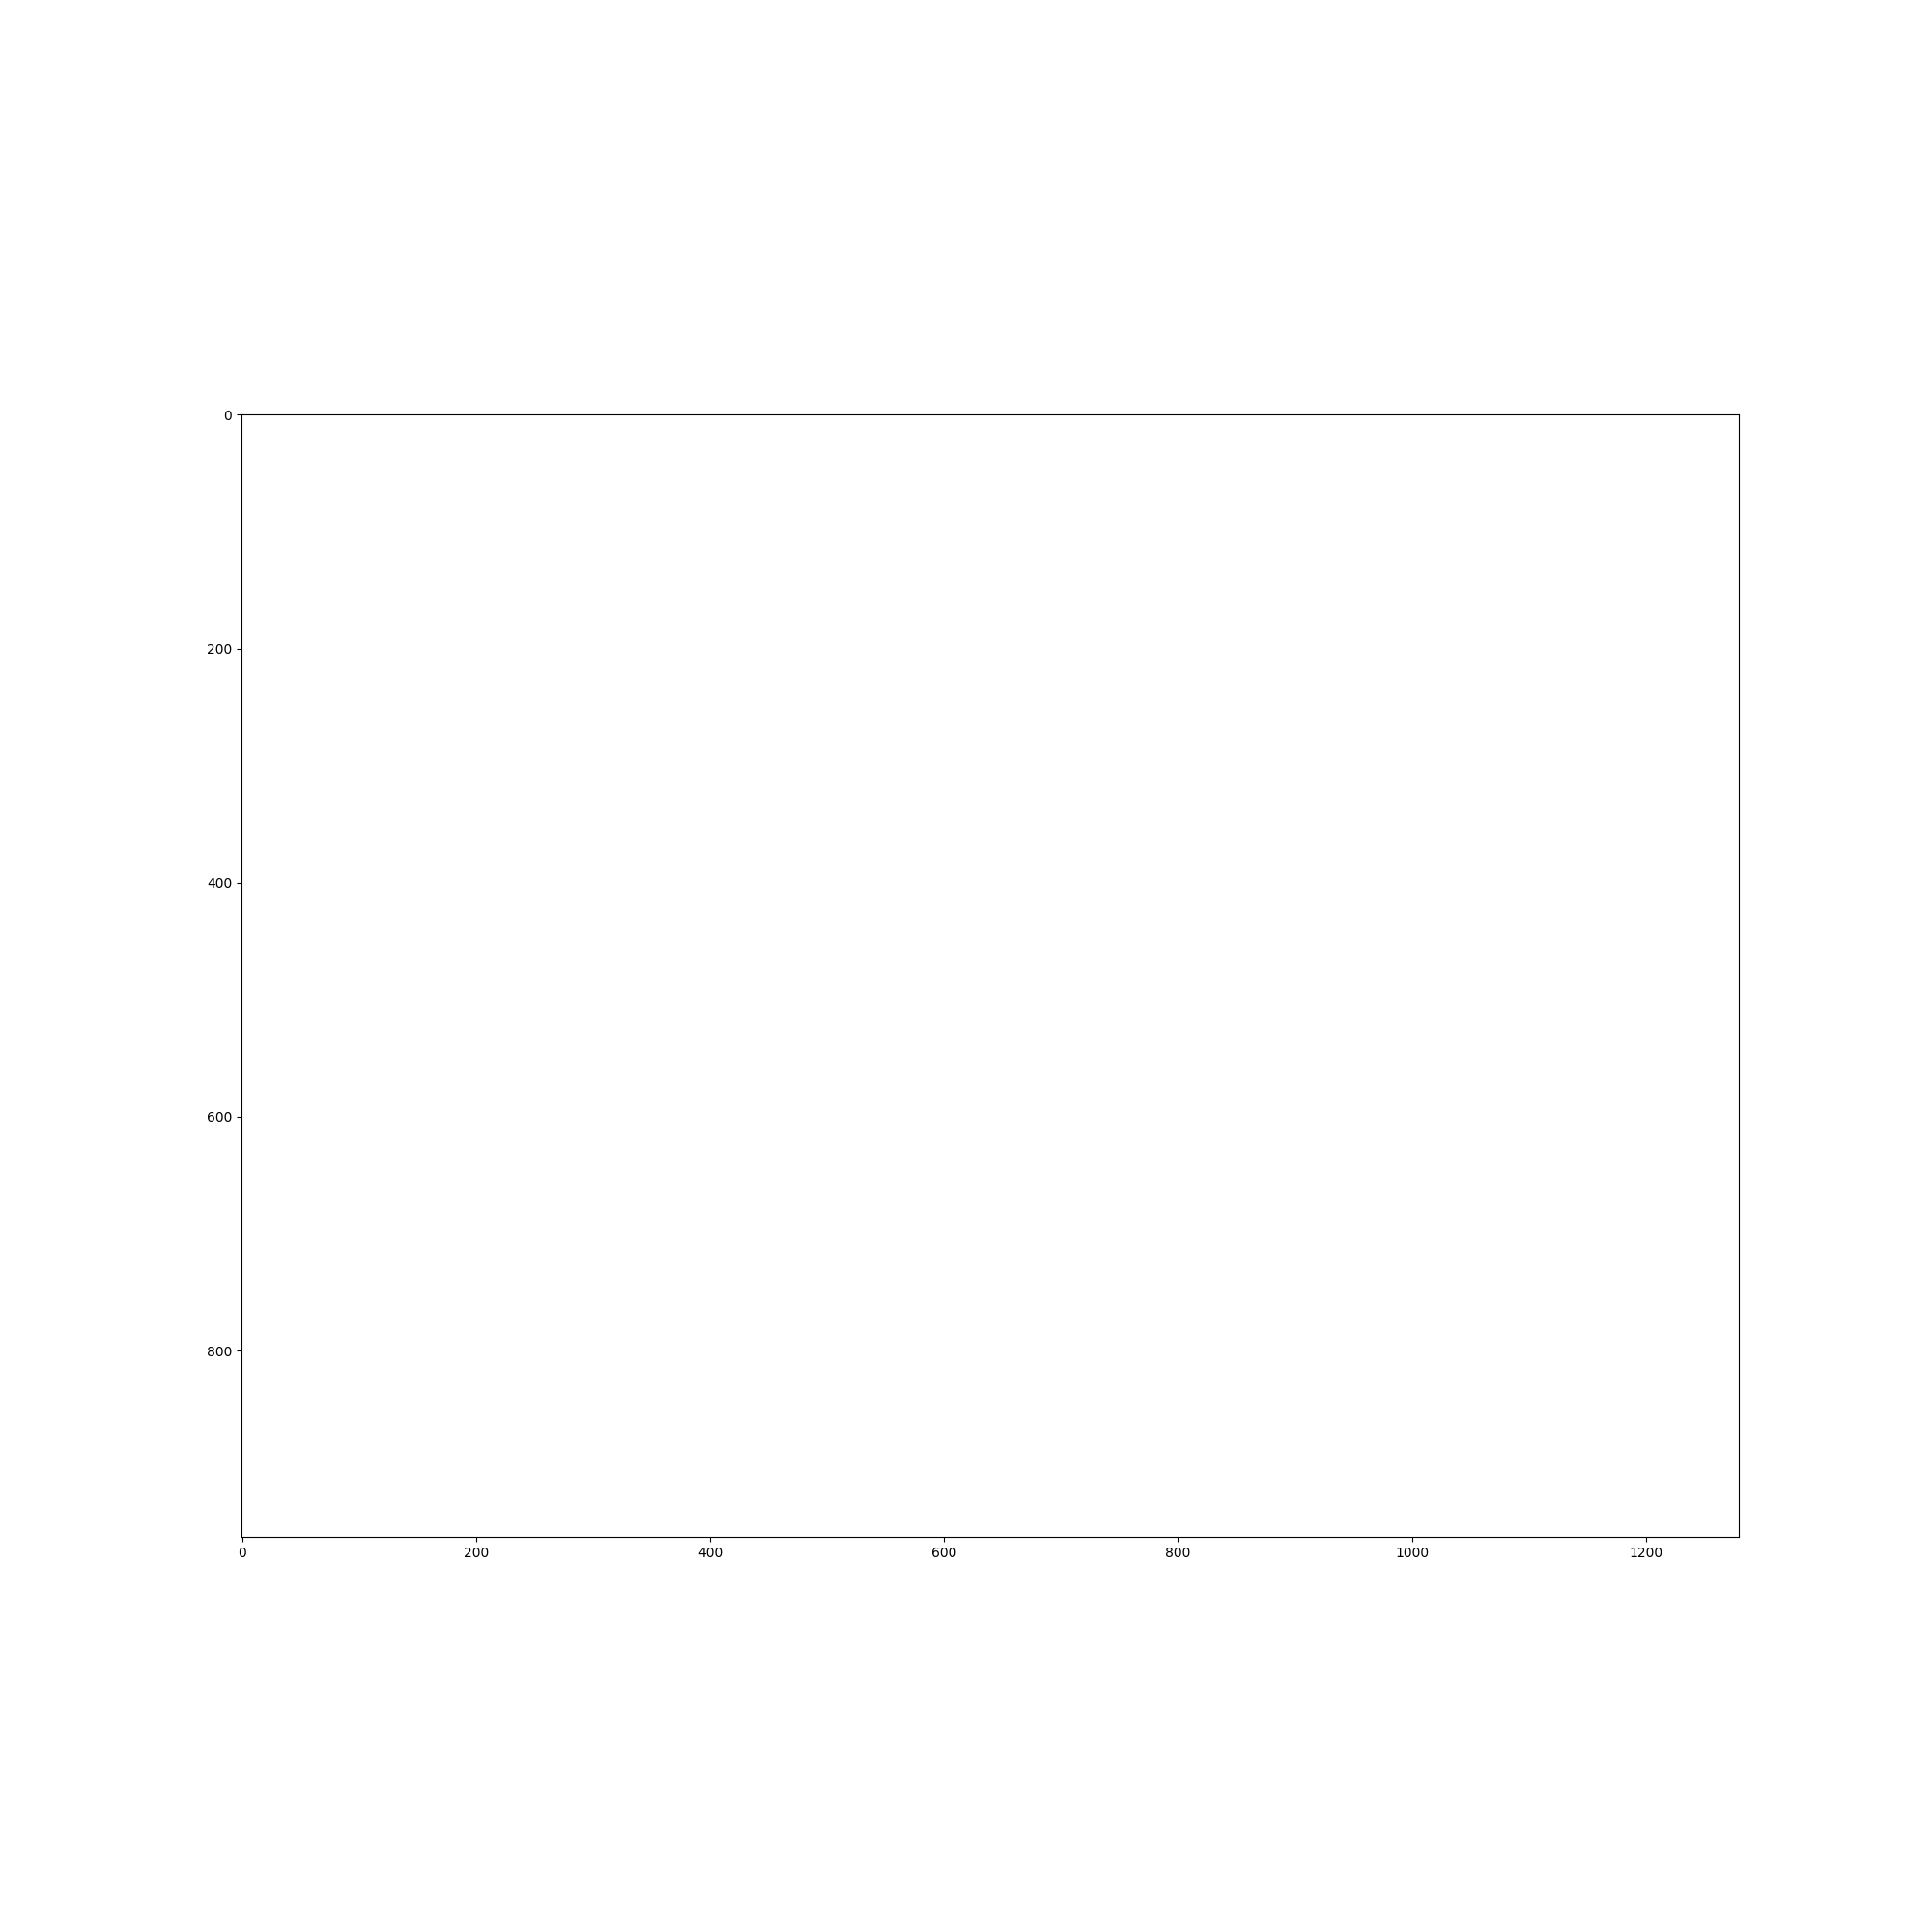

In [72]:
cam = pyrender.PerspectiveCamera(yfov=(np.pi / 3.0))
cam_pose = np.array([
    [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
    [1.0, 0.0,           0.0,           0.0],
    [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
    [0.0,  0.0,           0.0,          1.0]
])
bottle_pose = np.array([
    [1.0, 0.0,  0.0, 0.1],
    [0.0, 0.0, -1.0, -0.16],
    [0.0, 1.0,  0.0, 0.13],
    [0.0, 0.0,  0.0, 1.0],
])
scene = pyrender.Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))
bottle_node = scene.add(rSphere, pose=bottle_pose)
cam_node = scene.add(cam, pose=cam_pose)
r = pyrender.OffscreenRenderer(viewport_width=640*2, viewport_height=480*2)
color, depth = r.render(scene)
r.delete()
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(color)
plt.show()